In [85]:
#Libraries

import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn import linear_model
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Machine Learning models for exam

In [86]:
def accuracy(prediction,test): #Function that calculates accuracy measure based on predicted values and the test set
    errors = abs(prediction - test_labels)
    mape_temp = 100 * abs(errors / test_labels)
    mape=np.mean(mape_temp[~np.isinf(mape_temp)])
    accuracy=100-mape
    MSE=np.mean(np.square(errors))
    print('MAE:', round(np.mean(errors), 5), 'grades.')
    print('MAPE:', round(mape, 5), '%.')
    print('Accuracy:', round(accuracy, 5), '%.')
    print('MSE:', round(MSE, 5))

In [87]:
# Definer WAC-funktionen korrekt
def WAC(x):
    return np.average(x.fillna(0), weights=Data.loc[x.index, 'Fremmødte'])

# Set display option for Pandas
pd.set_option('display.max_columns', 50)

# Load the data
Data = pd.read_csv('ML_data.csv')

# Only use courses with grades (not pass/fail)
Data = Data.dropna(subset=['Moving_Average_GPA'])

# Select the features we want to use for prediction
Input_values = Data[['Course code', 'Year', 'Season', 'Antal bestået', 'Antal tilmeldte', 
                     'Eksamensgennemsnit', 'Moving_Average_GPA', 'Fremmødte', 'Point( ECTS )', 'Kursustype', 
                     'Evalueringsform', 'Bedømmelsesform', 'Institut'] + Data.columns.tolist()[-11:]]

# Extract the labels (target variable)
Output_values = np.array(Input_values['Eksamensgennemsnit'])

# Drop unnecessary columns from the input
Input_values = Input_values.drop(['Season', 'Institut', 'Course code', 'Kursustype', 'Eksamensgennemsnit'], axis=1)

# Replacing lack of prior course GPA with the overall weighted average
Input_values['Moving_Average_GPA'].fillna(WAC(Data['Eksamensgennemsnit']), inplace=True)

# Convert categorical variables into dummy variables
Input_values = pd.get_dummies(Input_values)

# Save column headers
Input_values_list = list(Input_values.columns)

# Convert the dataframe to a numpy array
Input_values = np.array(Input_values)

# Split the data into training and test sets
train_features, test_features, train_labels, test_labels = train_test_split(
    Input_values, Output_values, test_size=0.20, random_state=42)

# Print the shapes of the resulting datasets
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)


Training Features Shape: (5752, 61)
Training Labels Shape: (5752,)
Testing Features Shape: (1439, 61)
Testing Labels Shape: (1439,)


/var/folders/m3/mq_jwggj1sv__dm347vy0rqm0000gn/T/ipykernel_19240/2677176170.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Input_values['Moving_Average_GPA'].fillna(WAC(Data['Eksamensgennemsnit']), inplace=True)


## Ordinary Least Squares (OLS) Regression

In [88]:
#Scaling data
scaler=StandardScaler().fit(train_features)
sc_train_features=scaler.transform(train_features)
sc_test_features=scaler.transform(test_features)

In [89]:
#Fitting and OLS model on the training data
ols=linear_model.LinearRegression()
ols.fit(sc_train_features,train_labels)

LinearRegression()

In [90]:
#predicting using the trained OLS, and calculating the models accuracy
predict_ols = ols.predict(sc_test_features)
accuracy(predict_ols, test_labels)

MAE: 0.47439 grades.
MAPE: 8.96305 %.
Accuracy: 91.03695 %.
MSE: 0.53862


/var/folders/m3/mq_jwggj1sv__dm347vy0rqm0000gn/T/ipykernel_19240/979711943.py:3: RuntimeWarning: divide by zero encountered in divide
  mape_temp = 100 * abs(errors / test_labels)


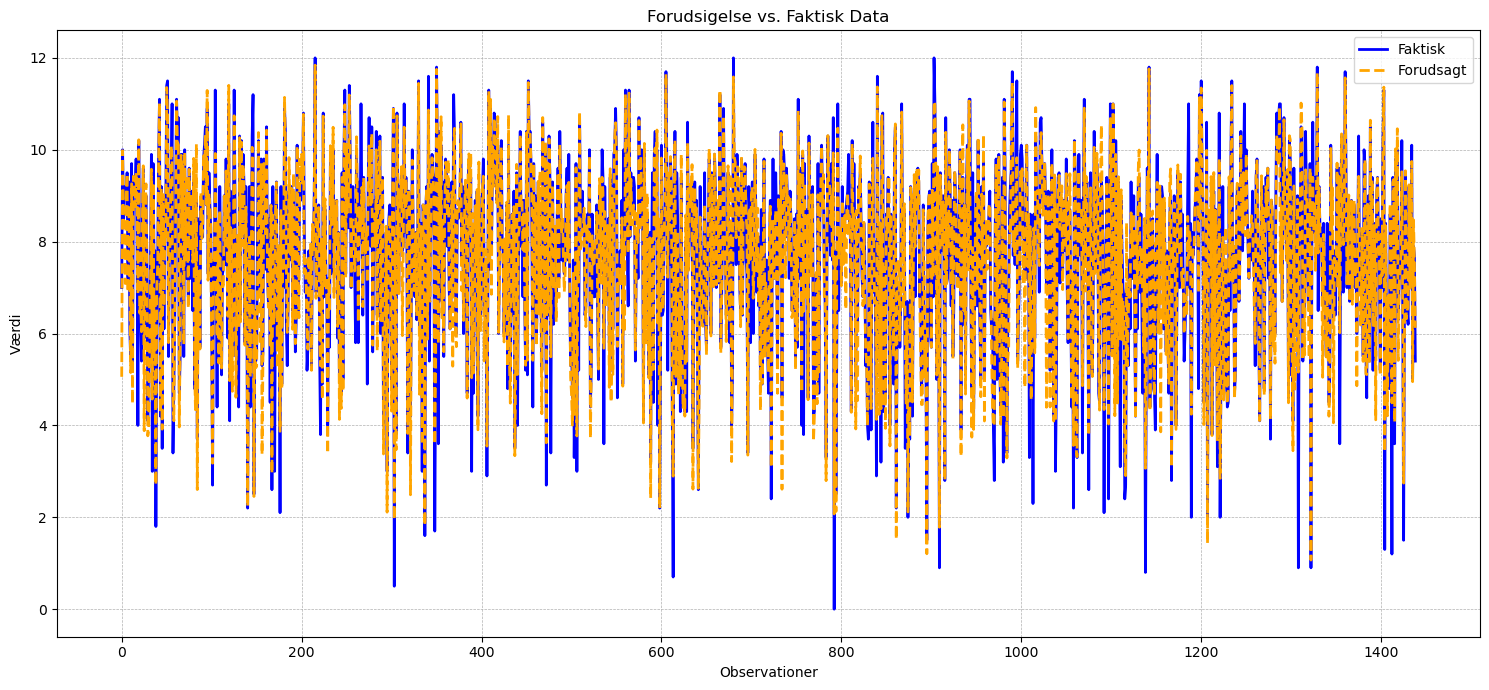

In [91]:
import matplotlib.pyplot as plt
import numpy as np

# Opret en række numre for x-aksen baseret på længden af dataene
x_axis = np.arange(len(test_labels))

plt.figure(figsize=(15,7))
plt.plot(x_axis, test_labels, label='Faktisk', color='blue', linewidth=2)
plt.plot(x_axis, predict_ols, label='Forudsagt', color='orange', linestyle='--', linewidth=2)
plt.title('Forudsigelse vs. Faktisk Data')
plt.xlabel('Observationer')
plt.ylabel('Værdi')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

## Lasso

In [92]:
#Training/fitting the lasso model and predict using the standardized alpha (hyperparameter lambda in report)
lasso_reg=Lasso()
lasso_reg.fit(sc_train_features,train_labels)
lasso_predict=lasso_reg.predict(sc_test_features)
accuracy(lasso_predict, test_labels)

MAE: 0.96284 grades.
MAPE: 19.3077 %.
Accuracy: 80.6923 %.
MSE: 1.54771


/var/folders/m3/mq_jwggj1sv__dm347vy0rqm0000gn/T/ipykernel_19240/979711943.py:3: RuntimeWarning: divide by zero encountered in divide
  mape_temp = 100 * abs(errors / test_labels)


In [93]:
#Using gridsearch to find optimal size of hyperparameter
lasso_reg=Lasso()
param_grid={'alpha':np.logspace(-4,4,12)}
grid_search_lasso = GridSearchCV(estimator = lasso_reg, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

grid_search_lasso.fit(sc_train_features,train_labels)
grid_search_lasso.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.451e+01, tolerance: 2.029e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.551e+01, tolerance: 2.032e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

[CV] END ........................alpha=0.0005336699231206312; total time=   0.4s
[CV] END ........................alpha=0.0005336699231206312; total time=   0.4s
[CV] END .......................................alpha=0.0001; total time=   0.4s
[CV] END .......................................alpha=0.0001; total time=   0.4s
[CV] END .......................................alpha=0.0001; total time=   0.5s
[CV] END .......................................alpha=0.0001; total time=   0.5s
[CV] END ........................alpha=0.0005336699231206312; total time=   0.5s
[CV] END .......................................alpha=0.0001; total time=   0.5s
[CV] END ..........................alpha=0.01519911082952933; total time=   0.0s
[CV] END ..........................alpha=0.01519911082952933; total time=   0.0s
[CV] END ..........................alpha=0.01519911082952933; total time=   0.0s
[CV] END ..........................alpha=0.01519911082952933; total time=   0.0s
[CV] END ...................

/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.691e+01, tolerance: 2.055e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.282e+01, tolerance: 2.028e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

{'alpha': 0.0001}

In [94]:
#Fitting the new model with the above optimal hyperparameter, predicting and calculating accuracy
best_grid_lasso = grid_search_lasso.best_estimator_
predictions_best_grid_lasso = best_grid_lasso.predict(sc_test_features)
accuracy(predictions_best_grid_lasso, test_labels)

MAE: 0.4745 grades.
MAPE: 8.95467 %.
Accuracy: 91.04533 %.
MSE: 0.53841


/var/folders/m3/mq_jwggj1sv__dm347vy0rqm0000gn/T/ipykernel_19240/979711943.py:3: RuntimeWarning: divide by zero encountered in divide
  mape_temp = 100 * abs(errors / test_labels)


### Plot of Lasso predictions

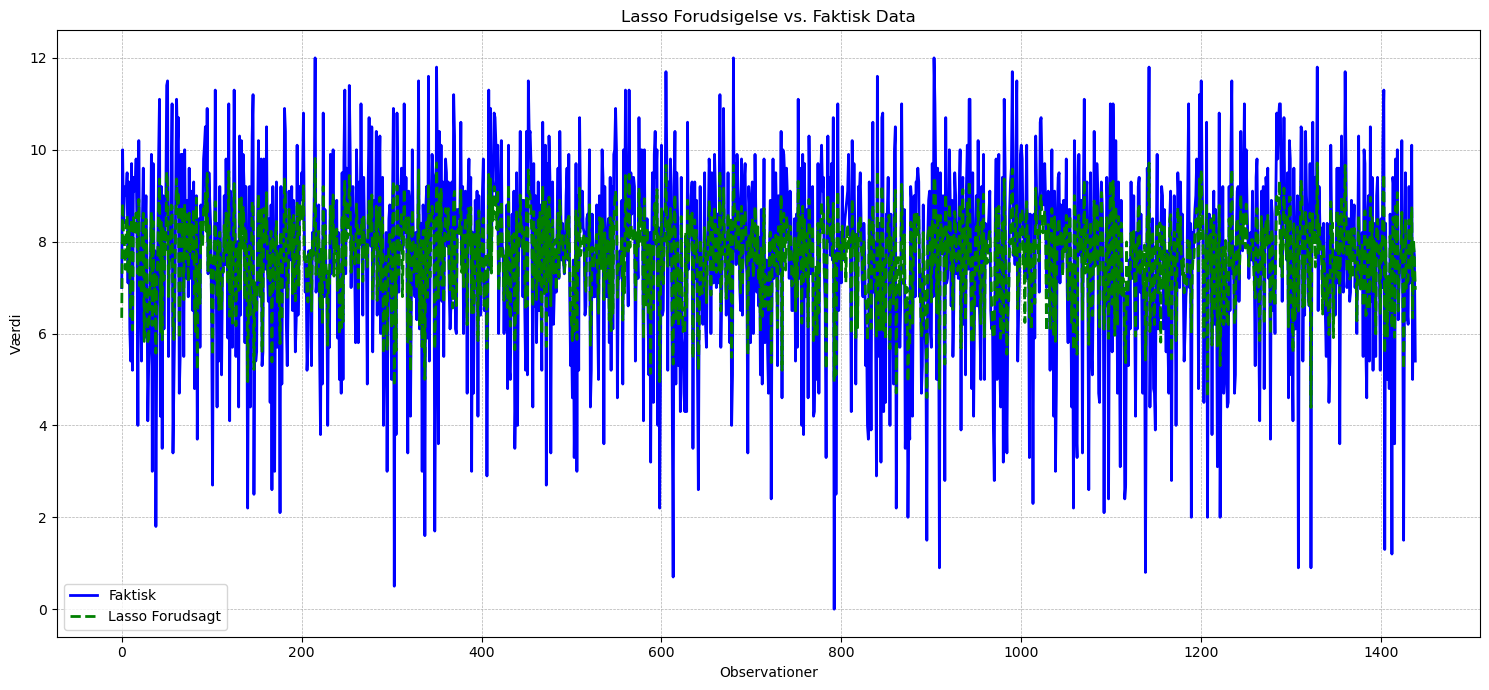

In [95]:
import matplotlib.pyplot as plt
import numpy as np

# Opret en række numre for x-aksen baseret på længden af dataene
x_axis = np.arange(len(test_labels))

plt.figure(figsize=(15,7))
plt.plot(x_axis, test_labels, label='Faktisk', color='blue', linewidth=2)
plt.plot(x_axis, lasso_predict, label='Lasso Forudsagt', color='green', linestyle='--', linewidth=2)
plt.title('Lasso Forudsigelse vs. Faktisk Data')
plt.xlabel('Observationer')
plt.ylabel('Værdi')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

### Coefficients from Lasso

In [96]:
# Hent koefficienterne fra den optimale Lasso-model
lasso_coefficients = best_grid_lasso.coef_

# Opret en DataFrame for bedre læsbarhed
coeff_df_lasso = pd.DataFrame(lasso_coefficients, Input_values_list, columns=['Coefficient'])
coeff_df_lasso = coeff_df_lasso.sort_values(by='Coefficient', key=lambda x: x.abs(), ascending=False)

coeff_df_lasso

,Coefficient
Moving_Average_GPA,1.934743
Fremmødte,-1.026712
Antal bestået,0.627257
Antal tilmeldte,0.443865
Year,-0.037604
...,...
Point( ECTS )_10,-0.000000
Point( ECTS )_5,0.000000
Point( ECTS )_5,0.000000
Moving_Average_GPA,0.000000


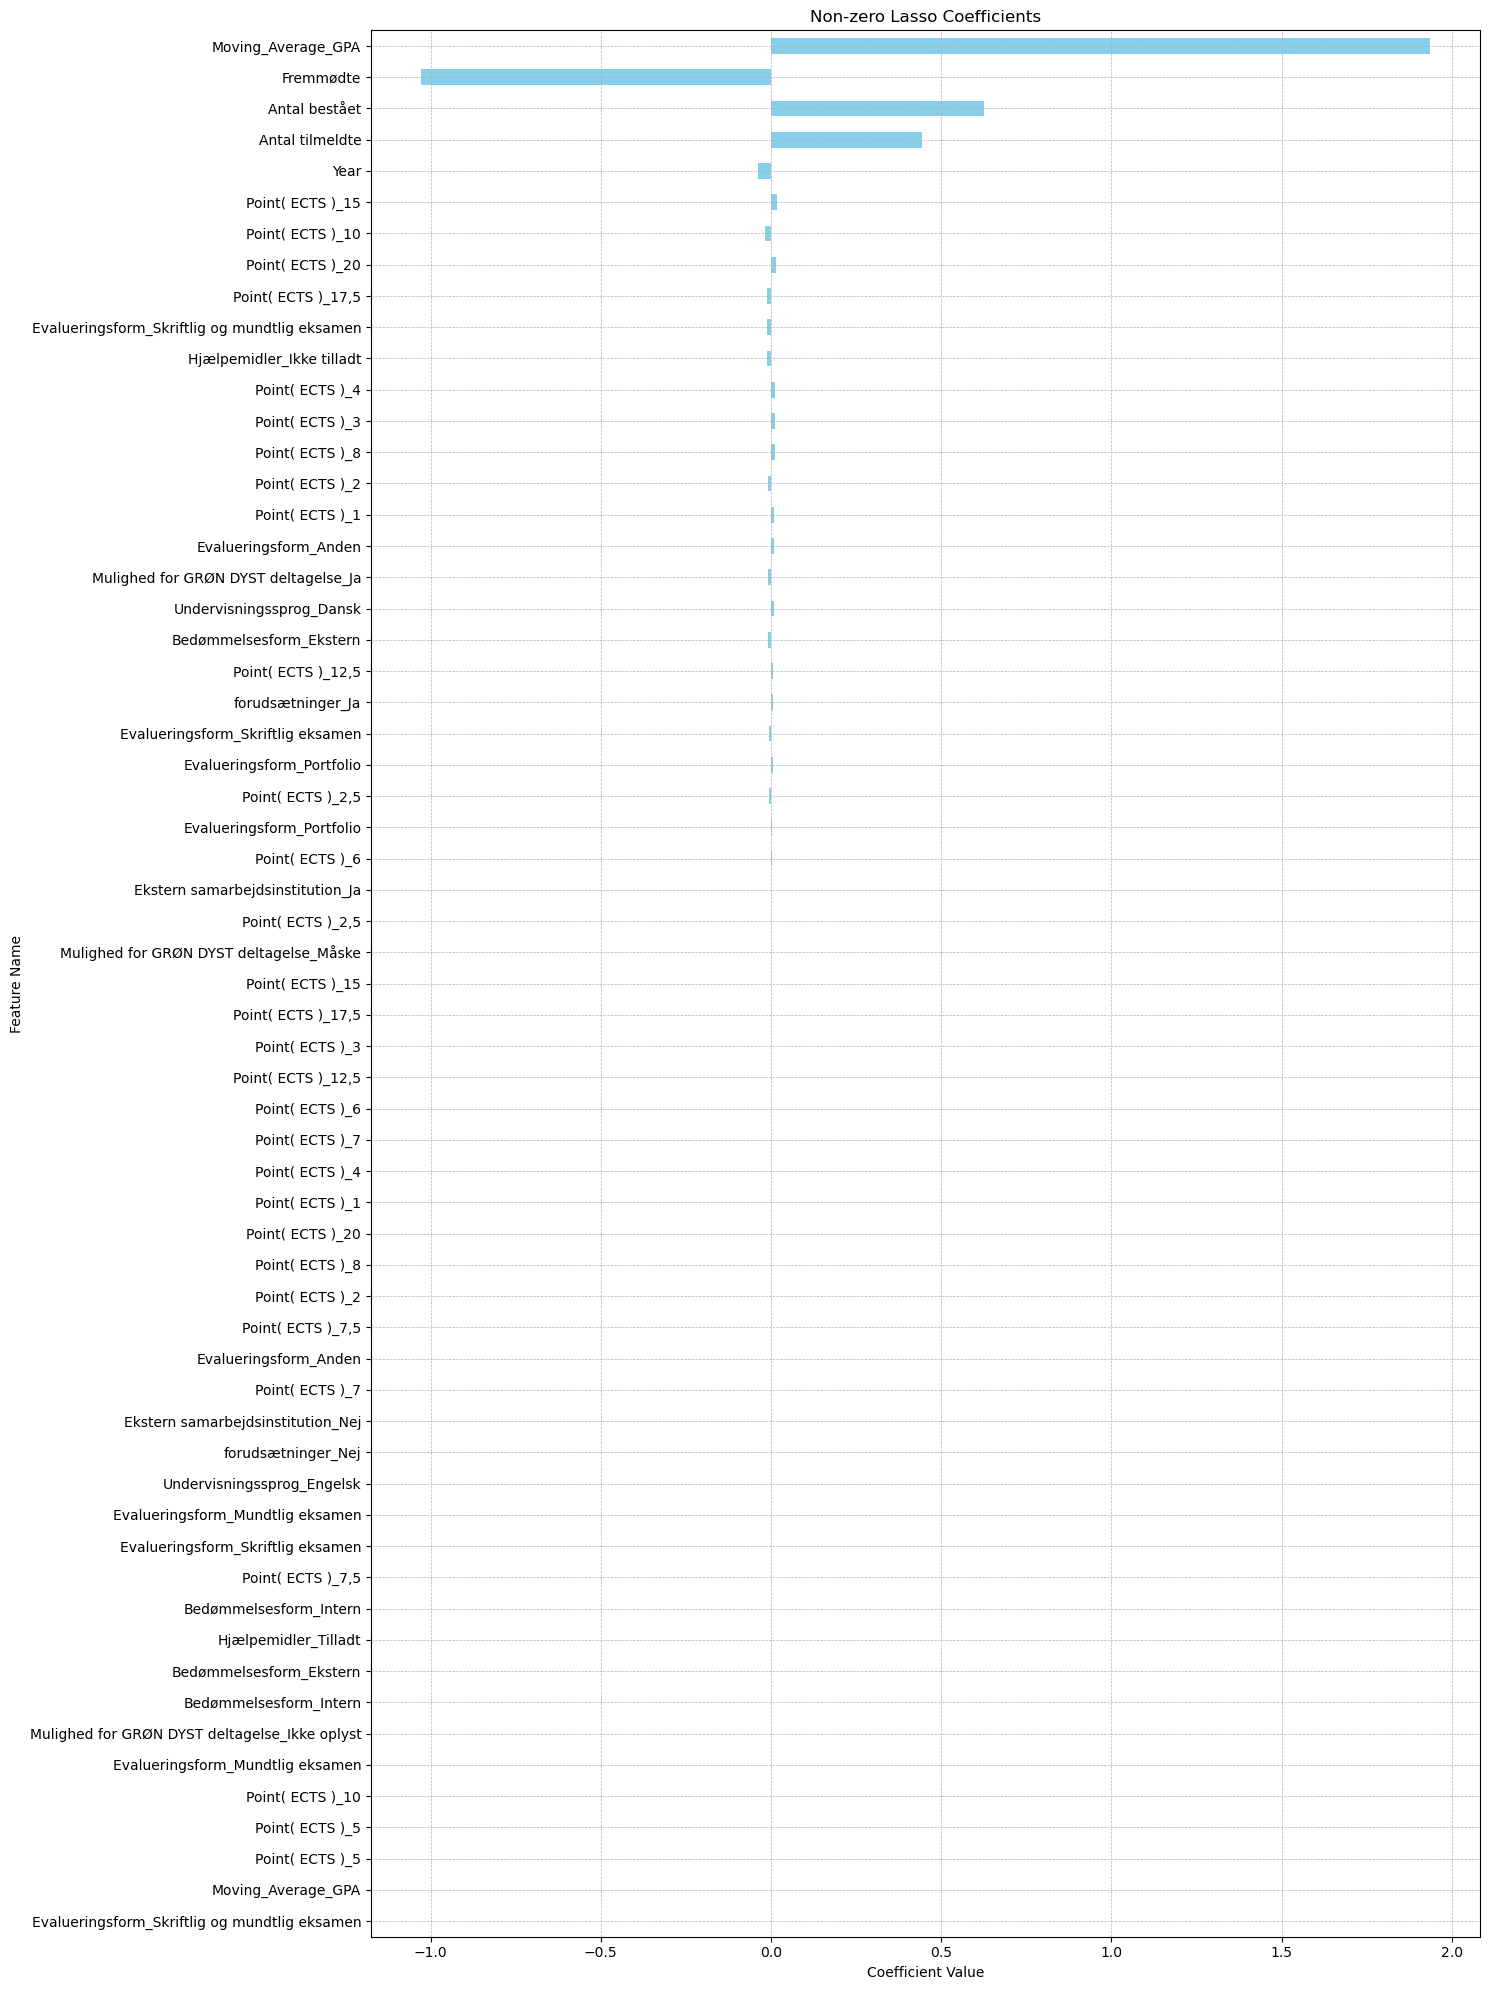

In [97]:
# Filter out zero coefficients
non_zero_coeffs = coeff_df_lasso

# Sort coefficients by absolute value for better visualization
sorted_coeffs = non_zero_coeffs.sort_values(by='Coefficient', key=lambda x: abs(x), ascending=False)

# Plot
plt.figure(figsize=(15,20))
sorted_coeffs['Coefficient'].plot(kind='barh', color='skyblue')
plt.title('Non-zero Lasso Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.gca().invert_yaxis()  # This will display the largest coefficients at the top
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

## Ridge

In [98]:
#Training/fitting the Ridge model and predict using the standardized alpha (hyperparameter lambda in report)
Ridge_reg=Ridge()
Ridge_reg.fit(sc_train_features,train_labels)
Ridge_predict=Ridge_reg.predict(sc_test_features)
accuracy(Ridge_predict, test_labels)

MAE: 0.47462 grades.
MAPE: 8.95676 %.
Accuracy: 91.04324 %.
MSE: 0.53853


/var/folders/m3/mq_jwggj1sv__dm347vy0rqm0000gn/T/ipykernel_19240/979711943.py:3: RuntimeWarning: divide by zero encountered in divide
  mape_temp = 100 * abs(errors / test_labels)


In [99]:
#Using gridsearch to find optimal size of hyperparameter, note that more possible alpha is being looked after
#as Ridge is significant faster than the Lasso model, requiring less computation power
Ridge_reg=Ridge()
param_grid={'alpha':np.logspace(-5,5,50)}
grid_search_Ridge = GridSearchCV(estimator = Ridge_reg, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

grid_search_Ridge.fit(sc_train_features,train_labels)
grid_search_Ridge.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END ........................................alpha=1e-05; total time=   0.0s[CV] END ........................................alpha=1e-05; total time=   0.0s

[CV] END ........................................alpha=1e-05; total time=   0.0s
[CV] END ........................................alpha=1e-05; total time=   0.0s
[CV] END ........................................alpha=1e-05; total time=   0.0s
[CV] END .......................alpha=1.5998587196060572e-05; total time=   0.0s
[CV] END .......................alpha=1.5998587196060572e-05; total time=   0.0s
[CV] END .......................alpha=1.5998587196060572e-05; total time=   0.0s
[CV] END .......................alpha=1.5998587196060572e-05; total time=   0.0s
[CV] END .......................alpha=1.5998587196060572e-05; total time=   0.0s
[CV] END ........................alpha=2.559547922699533e-05; total time=   0.0s
[CV] END ........................alpha=2.559547

{'alpha': 0.7906043210907702}

In [100]:
#Fitting the new model with the above optimal hyperparameter, predicting and calculating accuracy
best_grid_Ridge = grid_search_Ridge.best_estimator_
predictions_best_grid_Ridge = best_grid_Ridge.predict(sc_test_features)
accuracy(predictions_best_grid_Ridge, test_labels)

MAE: 0.47468 grades.
MAPE: 8.9578 %.
Accuracy: 91.0422 %.
MSE: 0.53857


/var/folders/m3/mq_jwggj1sv__dm347vy0rqm0000gn/T/ipykernel_19240/979711943.py:3: RuntimeWarning: divide by zero encountered in divide
  mape_temp = 100 * abs(errors / test_labels)


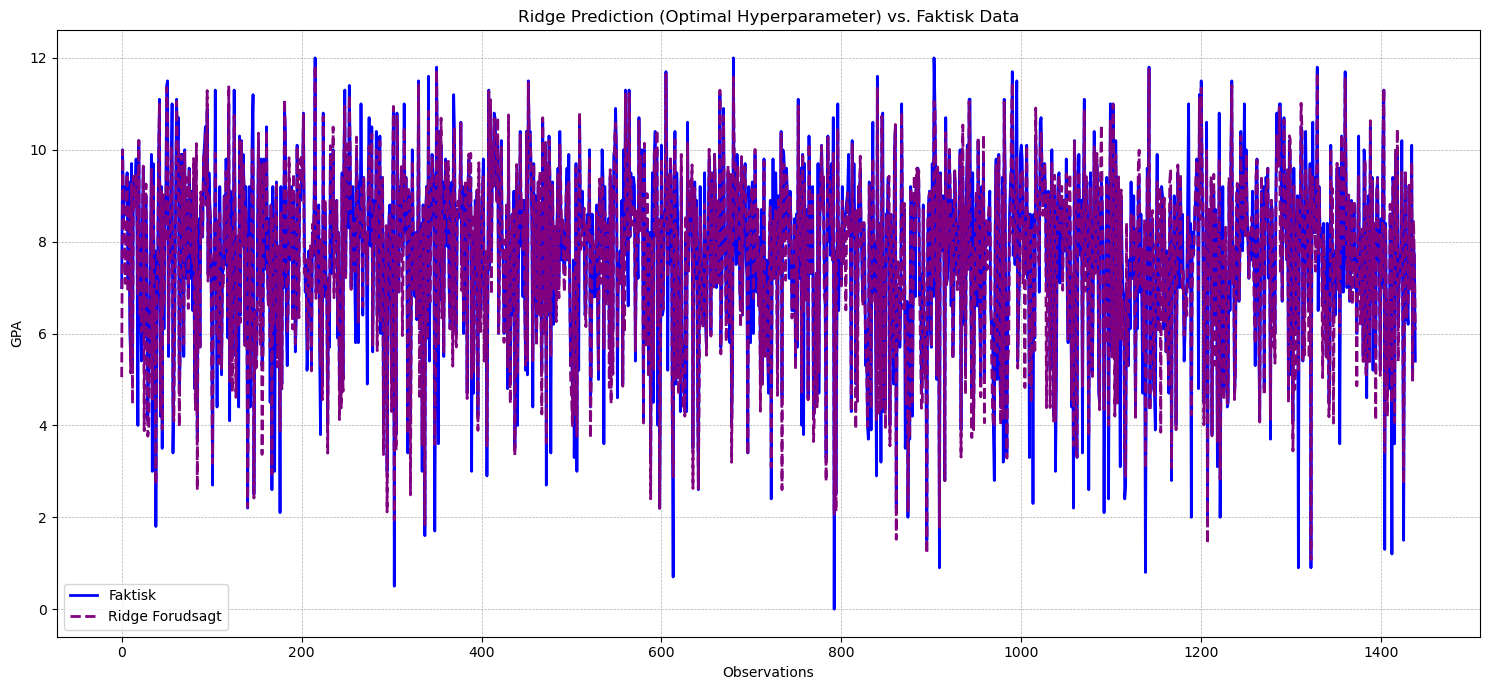

In [101]:
import matplotlib.pyplot as plt
import numpy as np

# Opret en række numre for x-aksen baseret på længden af dataene
x_axis = np.arange(len(test_labels))

plt.figure(figsize=(15,7))
plt.plot(x_axis, test_labels, label='Faktisk', color='blue', linewidth=2)
plt.plot(x_axis, predictions_best_grid_Ridge, label='Ridge Forudsagt', color='purple', linestyle='--', linewidth=2)
plt.title('Ridge Prediction (Optimal Hyperparameter) vs. Faktisk Data')
plt.xlabel('Observations')
plt.ylabel('GPA')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

### Coefficients for Ridge

In [102]:
# Hent koefficienterne fra den optimale Lasso-model
Ridge_coefficients = best_grid_Ridge.coef_

# Opret en DataFrame for bedre læsbarhed
coeff_df_ridge = pd.DataFrame(Ridge_coefficients, Input_values_list, columns=['Coefficient'])
coeff_df_ridge = coeff_df_ridge.sort_values(by='Coefficient', key=lambda x: x.abs(), ascending=False)

coeff_df_ridge[:97]

,Coefficient
Fremmødte,-1.145134
Moving_Average_GPA,0.967304
Moving_Average_GPA,0.967304
Antal bestået,0.650677
Antal tilmeldte,0.539313
...,...
"Point( ECTS )_7,5",0.000527
Point( ECTS )_7,0.000250
Point( ECTS )_7,0.000250
Evalueringsform_Mundtlig eksamen,-0.000114


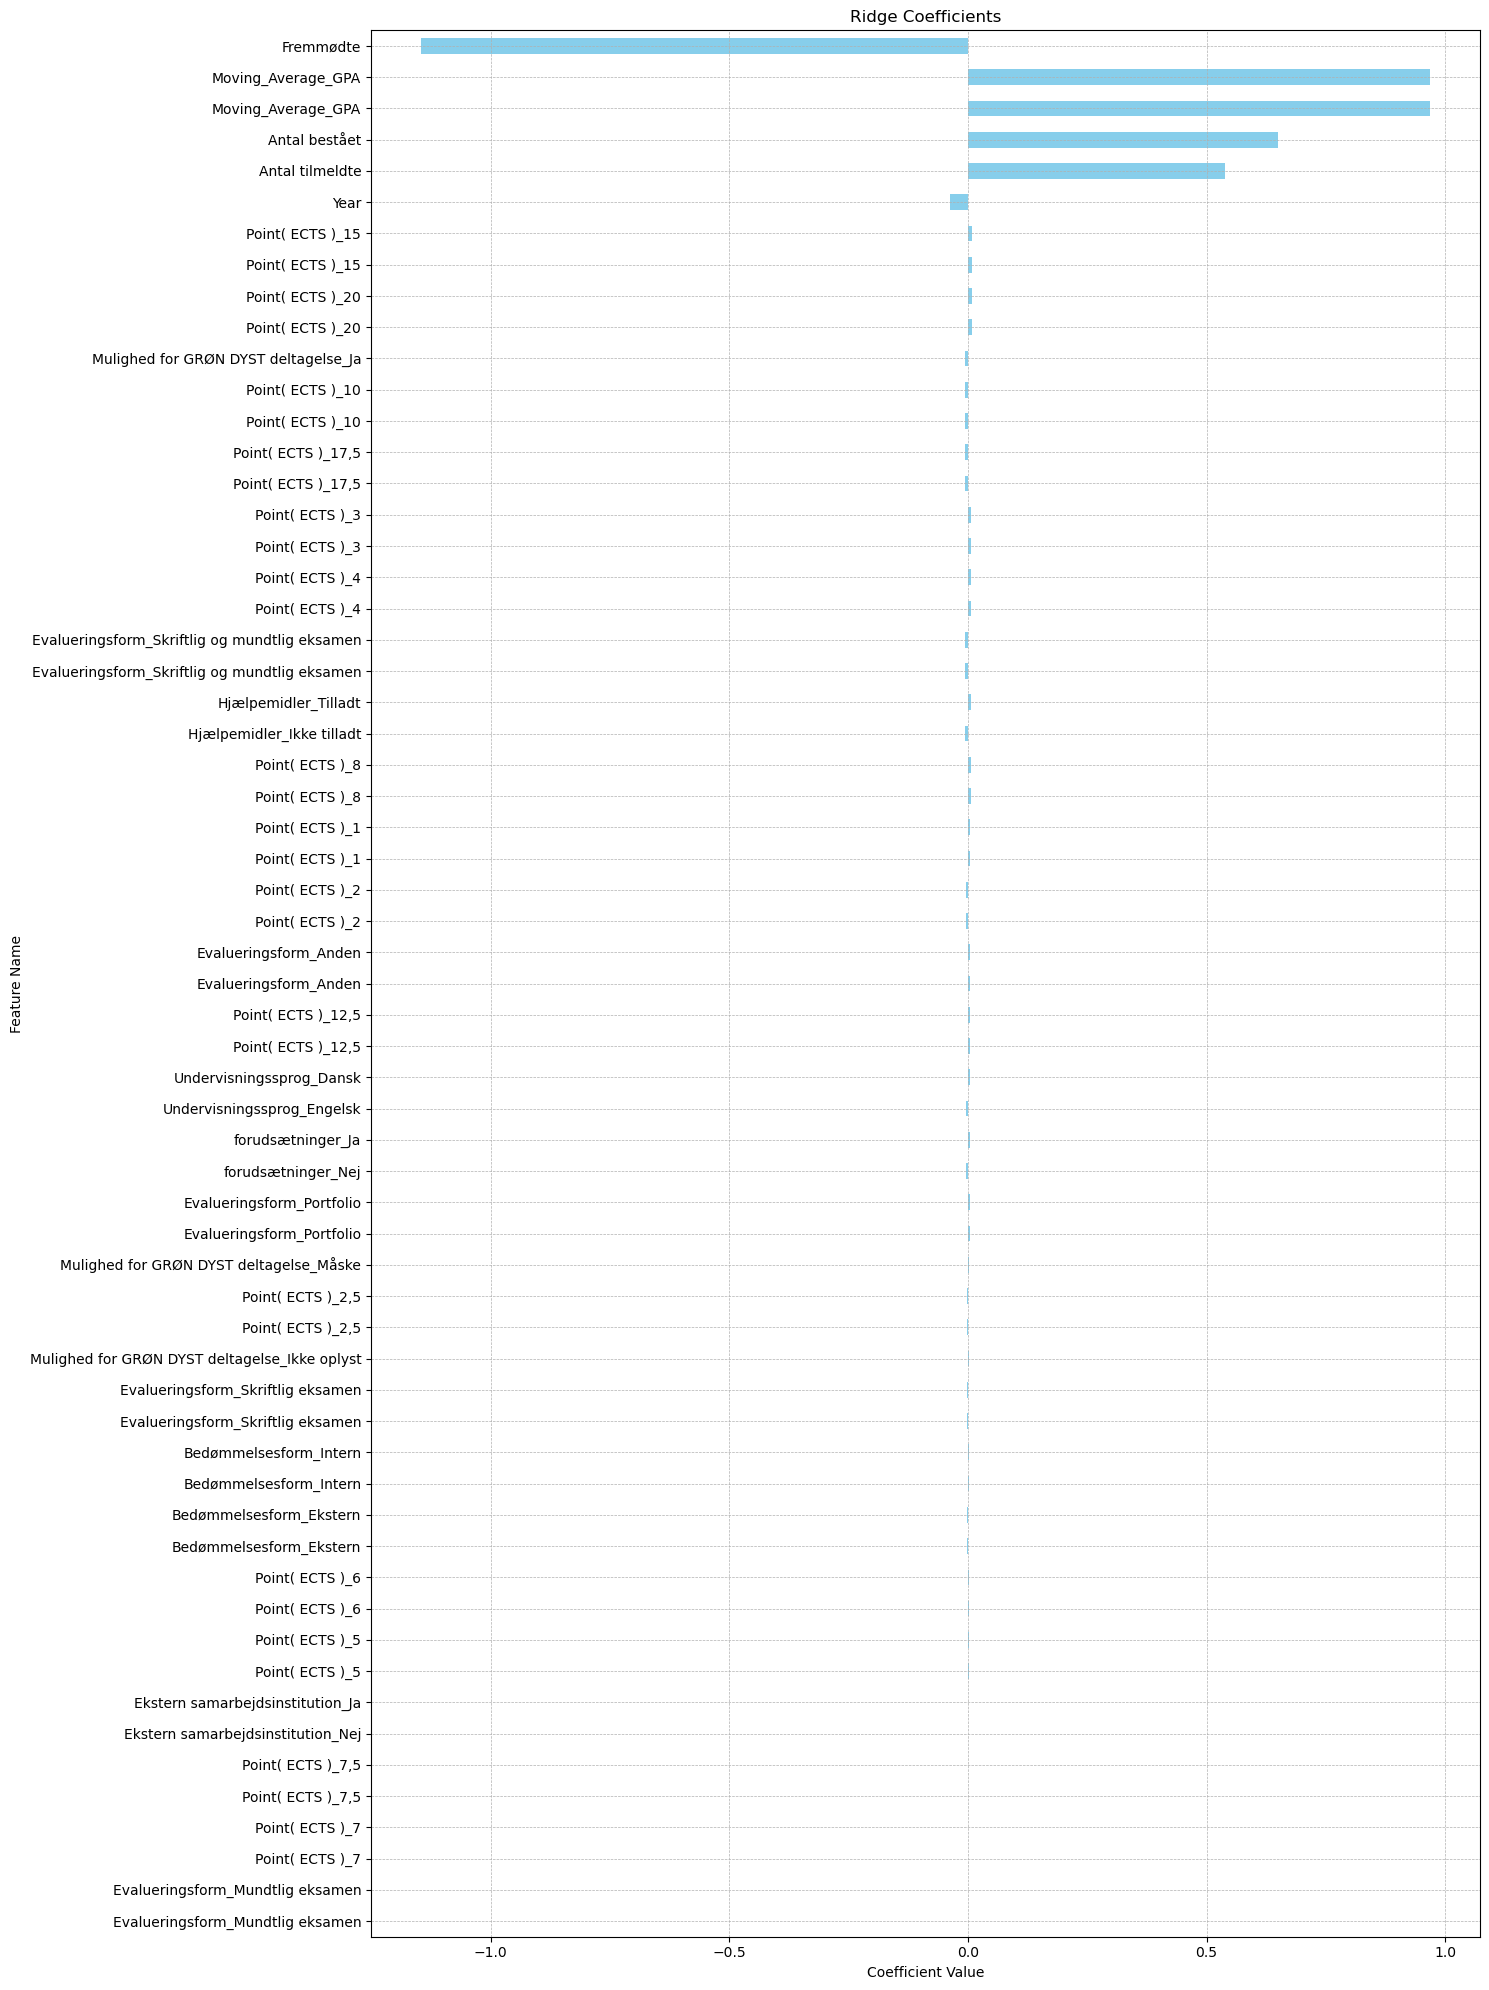

In [103]:
# Filter out zero coefficients
non_zero_coeffs = coeff_df_ridge

# Sort coefficients by absolute value for better visualization
sorted_coeffs = non_zero_coeffs.sort_values(by='Coefficient', key=lambda x: abs(x), ascending=False)

# Plot
plt.figure(figsize=(15,20))
sorted_coeffs['Coefficient'].plot(kind='barh', color='skyblue')
plt.title('Ridge Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.gca().invert_yaxis()  # This will display the largest coefficients at the top
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

## Random Forrest Regressor

In [104]:
#Beforehand -finding an baseline prediction to make sure machine learning better the prediction
# The baseline predictions are set to 7 (around average)
baseline_preds = 7
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

Average baseline error:  1.83


In [105]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels)

RandomForestRegressor(n_estimators=1000, random_state=42)

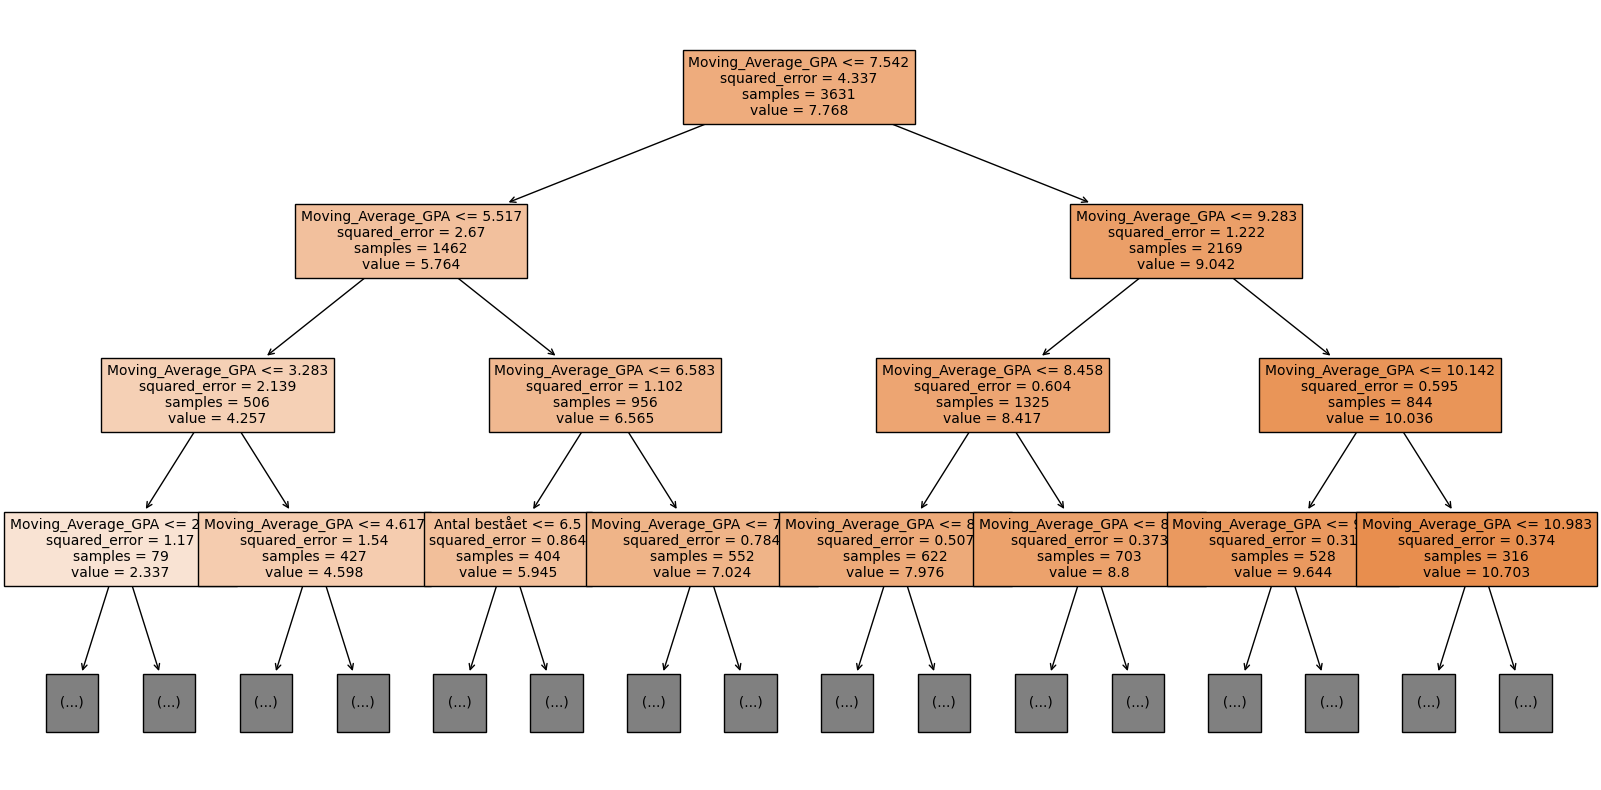

In [106]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Choose a tree from the forrest (in this case the first tree)
tree = rf.estimators_[0]

plt.figure(figsize=(20,10))
plot_tree(tree, filled=True, feature_names=Input_values_list, max_depth=3, fontsize=10)
plt.show()

In [107]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the accuracy measurements
accuracy(predictions,test_labels)

MAE: 0.48184 grades.
MAPE: 8.35426 %.
Accuracy: 91.64574 %.
MSE: 0.49513


/var/folders/m3/mq_jwggj1sv__dm347vy0rqm0000gn/T/ipykernel_19240/979711943.py:3: RuntimeWarning: divide by zero encountered in divide
  mape_temp = 100 * abs(errors / test_labels)


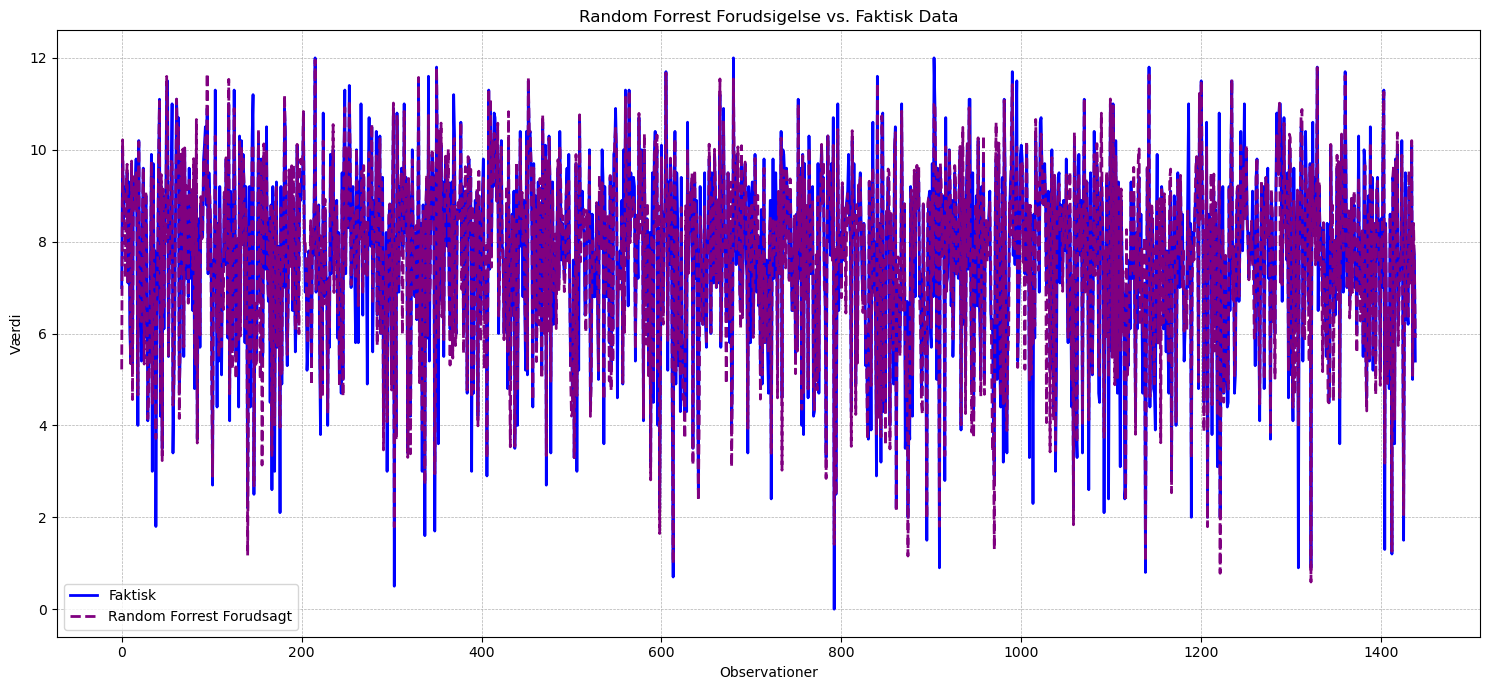

In [108]:
import matplotlib.pyplot as plt
import numpy as np

# Opret en række numre for x-aksen baseret på længden af dataene
x_axis = np.arange(len(test_labels))

plt.figure(figsize=(15,7))
plt.plot(x_axis, test_labels, label='Faktisk', color='blue', linewidth=2)
plt.plot(x_axis, predictions, label='Random Forrest Forudsagt', color='purple', linestyle='--', linewidth=2)
plt.title('Random Forrest Forudsigelse vs. Faktisk Data')
plt.xlabel('Observationer')
plt.ylabel('Værdi')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()